## Création d'un modele avec les données propres

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pickle
import re

In [2]:
data_full = pd.read_csv("immos_dataset_clean.csv",index_col=0)

In [3]:
data_full.shape

(1461, 146)

In [4]:
columns = data_full.columns.values
columns

array(['typeof', 'price', 'surface', 'field_surface', 'rooms', 'bedrooms',
       'balcony', 'parking', 'terrace_OUI', 'pool_OUI',
       'localisation_Andernos-les-Bains', 'localisation_Arcachon',
       'localisation_Artigues-près-Bordeaux', 'localisation_Arès',
       'localisation_Audenge', 'localisation_Auriolles',
       'localisation_Avensan', 'localisation_Bazas',
       'localisation_Beautiran', 'localisation_Belin-Béliet',
       'localisation_Belvès-de-Castillon',
       'localisation_Beychac-et-Caillau', 'localisation_Birac-sur-Trec',
       'localisation_Blaignan', 'localisation_Blanquefort',
       'localisation_Blaye', 'localisation_Bordeaux',
       'localisation_Bouliac', 'localisation_Bourg',
       'localisation_Branne', 'localisation_Bruges',
       'localisation_Bègles', 'localisation_Bégadan',
       'localisation_Cadillac', 'localisation_Camarsac',
       'localisation_Camblanes-et-Meynac', 'localisation_Canéjan',
       'localisation_Cap Ferret', 'localisation_C

In [5]:
data_full['price'].describe()

count    1.461000e+03
mean     1.193989e+06
std      9.448692e+05
min      3.590000e+05
25%      7.106000e+05
50%      9.000000e+05
75%      1.345500e+06
max      1.600000e+07
Name: price, dtype: float64

#### Test de suppression des prix trop important pour voir la modification sur la qualité du modele
Ca fonctionne mais pas sur que ca soit une bonne idée , la MAE passe de 330 à 243k , quand on supprime ces biens

In [6]:
data_full.shape

(1461, 146)

In [7]:
important_prices = data_full.loc[data_full['price'] > 3000000]
print(len(important_prices))

48


In [8]:
print(len(important_prices)/data_full.shape[0]*100)

3.285420944558522


In [9]:
data_full = data_full.drop(important_prices.index, axis=0)

In [10]:
data_full.shape

(1413, 146)

In [11]:
data_full['price'].describe()

count    1.413000e+03
mean     1.074968e+06
std      5.250043e+05
min      3.590000e+05
25%      7.000000e+05
50%      8.925000e+05
75%      1.290000e+06
max      3.000000e+06
Name: price, dtype: float64

Log Price
- penser a exp les predictions pour avoir le vrai chiffre

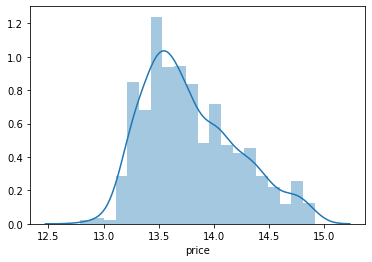

In [12]:
data_full['price'] = np.log(data_full['price'])
sns.distplot(data_full['price'])

#### Split Train / Val

In [13]:
target_column = 'price'
y_train_full_log = data_full[target_column].values
X_train_full = data_full.drop(target_column, axis=1).values

In [14]:
SEED = 42
np.random.seed(SEED)

In [15]:
X_train, X_val, y_train_log, y_val_log = train_test_split(X_train_full, y_train_full_log, test_size=0.1)

In [16]:
print(f"Train full shape : {data_full.shape}")
print(f"X_train shape : {X_train.shape}")
print(f"X_val shape : {X_val.shape}")
print(f"y_train_log shape : {y_train_log.shape}")
print(f"y_val_log shape : {y_val_log.shape}")

Train full shape : (1413, 146)
X_train shape : (1271, 145)
X_val shape : (142, 145)
y_train_log shape : (1271,)
y_val_log shape : (142,)


#### Scaler
Essai pour trouver le meilleur scaler pour nos datas

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [18]:
scalers = [
    MinMaxScaler(),
    MaxAbsScaler(),
    StandardScaler(),
    RobustScaler(),
    Normalizer(),
    QuantileTransformer(),
    PowerTransformer()
]

In [19]:
print("Recherche du meilleur scaler pour nos données")
print("_____________________________________________")
best_score = 0
best_scaler = "Null" 
for scaler in scalers:
    pipe = Pipeline(steps=[('scaler', scaler),('Ridge', Ridge())])
    pipe.fit(X_train,y_train_log)
    print(scaler)
    score = pipe.score(X_val,y_val_log)
    print(score)
    if score > best_score:
        best_score = score
        best_scaler = scaler    
    print("_____________________________________________")
print(f"Meilleur scaler {best_scaler} , score : {best_score}")

Recherche du meilleur scaler pour nos données
_____________________________________________
MinMaxScaler(copy=True, feature_range=(0, 1))
0.43993975199322344
_____________________________________________
MaxAbsScaler(copy=True)
0.43979902993292924
_____________________________________________
StandardScaler(copy=True, with_mean=True, with_std=True)
0.4292544863873051
_____________________________________________
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
0.438309998182711
_____________________________________________
Normalizer(copy=True, norm='l2')
0.07416165401496866
_____________________________________________
QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)
0.5583842964044046
_____________________________________________


C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
0.5292861278105099
_____________________________________________
Meilleur scaler QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000) , score : 0.5583842964044046


#### Pipeline

In [20]:
steps = [('scaler', best_scaler) , ('Ridge', Ridge())]
pipeline = Pipeline(steps)

In [21]:
parameters = {'Ridge__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],'Ridge__alpha': [1e-10,1e-5,1,10,100]}

In [22]:
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [23]:
grid.fit(X_train,y_train_log)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        QuantileTransformer(copy=True,
                                                            ignore_implicit_zeros=False,
                                                            n_quantiles=1000,
                                                            output_distribution='uniform',
                                                            random_state=None,
                                                            subsample=100000)),
                                       ('Ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                      

In [24]:
# Verifie la perfomance sur le val set ? 
# Utilise le scorer du modele si pas précisé dans scoring ? Ridge = R2
grid.score(X_val,y_val_log)

0.5586522023327198

In [25]:
grid.best_params_

{'Ridge__alpha': 1, 'Ridge__solver': 'lsqr'}

In [26]:
y_val_log_predict = grid.best_estimator_.predict(X_val)

In [27]:
print(f" MAE sur val : { round(mean_absolute_error(np.exp(y_val_log),np.exp(y_val_log_predict)),2) } Euros ")

 MAE sur val : 243362.63 Euros 


In [28]:
# Enregistre le modele
pickle.dump(grid, open('realestate_model.pickle', 'wb'))

#### Test prédiction sur nouvel input

[Lien vers l'annonce pour le test](https://www.lux-residence.com/fr/vente/appartement/AQUITAINE/33/BORDEAUX/AD27BC69-A9CA-2C57-BD9D-98BCC1529092/)

In [29]:
data_full.head(1)

,typeof,price,surface,field_surface,rooms,bedrooms,balcony,parking,terrace_OUI,pool_OUI,...,localisation_Soussac,localisation_Tabanac,localisation_Talence,localisation_Targon,localisation_Taussat,localisation_Teuillac,localisation_Thénac,localisation_Vendays-Montalivet,localisation_Villenave-d'Ornon,localisation_Yvrac
0,3,14.437699,475.0,15000.0,11.0,6.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0


Pour choisir la ville sans avoir a tout tapper , ou copier/coller ( sera utile dans le code de l'API ) 
- on cherche toutes les colonnes qui commence par " localisation_ " 
- On fait un dictionnaire avec ces colonnes avec toutes les valeurs à zéro
- On passe une des clés a 1 ( la ville ou on veut faire la prédiction )
- Et on ajoute enfin ce dictionnaire au premier dictionnaire comprenant le début du nouvel input dont on veut prédire le prix

In [30]:
list_localisation = []
for column in columns:
    localisation = re.search("^localisation_",column)
    if(localisation):
        list_localisation.append(column)

In [31]:
list_villes = []
for localisation in list_localisation:
    ville = localisation.replace("localisation_","")
    list_villes.append(ville)
list_villes

print(list_villes)

pickle.dump(list_villes, open('list_villes.pickle', 'wb'))

['Andernos-les-Bains', 'Arcachon', 'Artigues-près-Bordeaux', 'Arès', 'Audenge', 'Auriolles', 'Avensan', 'Bazas', 'Beautiran', 'Belin-Béliet', 'Belvès-de-Castillon', 'Beychac-et-Caillau', 'Birac-sur-Trec', 'Blaignan', 'Blanquefort', 'Blaye', 'Bordeaux', 'Bouliac', 'Bourg', 'Branne', 'Bruges', 'Bègles', 'Bégadan', 'Cadillac', 'Camarsac', 'Camblanes-et-Meynac', 'Canéjan', 'Cap Ferret', 'Carcans', 'Cardan', 'Carignan-de-Bordeaux', 'Casteljaloux', 'Cestas', 'Cocumont', 'Coutras', 'Créon', 'Cénac', 'Duras', 'Eynesse', 'Eysines', 'Fargues-Saint-Hilaire', 'Floirac', 'Fours', 'Fronsac', 'Galgon', 'Gradignan', 'Grignols', 'Grézillac', 'Gujan-Mestras', 'Illats', 'Izon', 'La Brède', 'La Réole', 'La Teste-de-Buch', 'Lacanau', 'Lalande-de-Pomerol', 'Langoiran', 'Langon', 'Latresne', 'Le Barp', 'Le Bouscat', 'Le Canon', 'Le Haillan', 'Le Pian-Médoc', 'Le Taillan-Médoc', 'Le Verdon-sur-Mer', 'Lesparre-Médoc', 'Lestiac-sur-Garonne', 'Libourne', 'Lormont', 'Lège-Cap-Ferret', 'Léognan', 'Marcheprime', 'M

In [32]:
dict_localisation = { i : [0] for i in list_localisation }

In [33]:
dict_localisation['localisation_Bordeaux'] = [1]

In [34]:
# dict = {
#     'typeof': [3],
#     'surface': [305],
#     'field_surface': [0],
#     'rooms': [9],
#     'bedrooms': [4],
#     'balcony': [1],
#     'parking': [2],
#     'terrace_OUI': [1],
#     'pool_OUI': [0]
# }
dict = {
    'typeof': [1],
    'surface': [220],
    'field_surface': [0],
    'rooms': [9],
    'bedrooms': [4],
    'balcony': [0],
    'parking': [0],
    'terrace_OUI': [0],
    'pool_OUI': [0]
}

In [35]:
dict.update(dict_localisation)

In [36]:
dict

{'typeof': [1],
 'surface': [220],
 'field_surface': [0],
 'rooms': [9],
 'bedrooms': [4],
 'balcony': [0],
 'parking': [0],
 'terrace_OUI': [0],
 'pool_OUI': [0],
 'localisation_Andernos-les-Bains': [0],
 'localisation_Arcachon': [0],
 'localisation_Artigues-près-Bordeaux': [0],
 'localisation_Arès': [0],
 'localisation_Audenge': [0],
 'localisation_Auriolles': [0],
 'localisation_Avensan': [0],
 'localisation_Bazas': [0],
 'localisation_Beautiran': [0],
 'localisation_Belin-Béliet': [0],
 'localisation_Belvès-de-Castillon': [0],
 'localisation_Beychac-et-Caillau': [0],
 'localisation_Birac-sur-Trec': [0],
 'localisation_Blaignan': [0],
 'localisation_Blanquefort': [0],
 'localisation_Blaye': [0],
 'localisation_Bordeaux': [1],
 'localisation_Bouliac': [0],
 'localisation_Bourg': [0],
 'localisation_Branne': [0],
 'localisation_Bruges': [0],
 'localisation_Bègles': [0],
 'localisation_Bégadan': [0],
 'localisation_Cadillac': [0],
 'localisation_Camarsac': [0],
 'localisation_Camblanes

In [37]:
df_pred = pd.DataFrame(dict)
df_pred

,typeof,surface,field_surface,rooms,bedrooms,balcony,parking,terrace_OUI,pool_OUI,localisation_Andernos-les-Bains,...,localisation_Soussac,localisation_Tabanac,localisation_Talence,localisation_Targon,localisation_Taussat,localisation_Teuillac,localisation_Thénac,localisation_Vendays-Montalivet,localisation_Villenave-d'Ornon,localisation_Yvrac
0,1,220,0,9,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
X_new = df_pred.values

In [39]:
X_new

array([[  1, 220,   0,   9,   4,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)

### Prediction
Test avec l'input
![photo d'appartement](input2.jpg)

In [42]:
new_pred2 = grid.best_estimator_.predict(X_new)

In [43]:
int(np.exp(new_pred2[0]))

1188110

In [ ]:
# model = pickle.load(open('realestate_model', 'rb'))